In [1]:
import pandas as pd
import ast
import re
from collections import Counter
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
all_data_ref = pd.read_parquet('astronomy_data_ref.parquet')

In [3]:
all_data_ref.shape

(255008, 15)

In [44]:
all_data_ref.first_author_aff_country_final_valid.isna().sum(
    axis=0
)

14551

In [4]:
# in the references there is no 'ApJL', they appear as 'ApJ' that is why it is important to merge them with ApJ in journals
all_data_ref['journal'] = all_data_ref['journal'].replace('ApJL', 'ApJ')


In [5]:
all_data_ref['reference_journal_counts'] = all_data_ref['reference_journals'].apply(
    lambda x: dict(Counter(x)) 
)
all_data_ref['reference_journal_counts'].head(4)

0    {'ApJ': 12, 'MNRAS': 17, 'PhR': 1, 'nrfa': 1, ...
1    {'ApJ': 19, 'A&A': 13, 'MNRAS': 5, 'grle': 1, ...
2    {'ApJ': 22, 'lssu': 1, 'A&A': 1, 'Sci': 1, 'NA...
3    {'ApJ': 19, 'egsp': 1, 'dvga': 1, 'MNRAS': 5, ...
Name: reference_journal_counts, dtype: object

In [6]:
def get_top_journals(df, journal_col='journal', top_n=10):
    """
    Returns the top N most frequent journals across the entire dataset.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        journal_col (str): Column name containing journal names.
        top_n (int): Number of top journals to retrieve.

    Returns:
        pd.DataFrame: DataFrame with columns 'journal' and 'count'.
    """
    top_journals = df[journal_col].value_counts().head(top_n)
    return pd.DataFrame({
        'journal': top_journals.index,
        'count': top_journals.values
    })
top_journals = get_top_journals(all_data_ref, journal_col='journal', top_n=3)
print (top_journals['count'].sum()/len(all_data_ref))
print(top_journals)


0.6176159179319864
  journal  count
0     ApJ  65402
1   MNRAS  52887
2     A&A  39208


In [7]:
astro_top_journal_list = top_journals['journal'].tolist() + ['Sci', 'Natur', 'NatAs']
astro_top_journal_list

['ApJ', 'MNRAS', 'A&A', 'Sci', 'Natur', 'NatAs']

In [8]:
def get_selected_journal_stats(
    df, journal_list, years=None, keyword='ALL', keyword_col='my_keyword', journal_col='journal', year_col='year'
):
    """
    Calculates the number and fraction of articles for a given list of journals, optionally filtered by year and keyword.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        journal_list (list): List of journal names to consider.
        years (tuple or list): Optional (start_year, end_year) tuple to filter by publication year.
        keyword (str): Keyword to filter by in the keyword_col. Use 'ALL' to skip filtering.
        keyword_col (str): Column name for keywords.
        journal_col (str): Column name for journal names.
        year_col (str): Column name for publication year.

    Returns:
        pd.DataFrame: DataFrame with journal, count, and fraction columns.
    """
    # Apply year filtering
    if years:
        start_year, end_year = years
        df = df[(df[year_col] >= start_year) & (df[year_col] <= end_year)]

    # Apply keyword filtering
    if keyword != 'ALL':
        df = df[df[keyword_col] == keyword]

    total_articles = len(df)

    # Count selected journals
    filtered = df[df[journal_col].isin(journal_list)]
    counts = filtered[journal_col].value_counts().reindex(journal_list, fill_value=0)

    result_df = pd.DataFrame({
        'journal': counts.index,
        'count': counts.values,
        'fraction': counts.values / total_articles if total_articles > 0 else 0
    })

    return result_df


journal_stats = get_selected_journal_stats(
    df=all_data_ref,
    journal_list=astro_top_journal_list,
    years=(2020, 2025),
    keyword='ALL'
)
print(journal_stats)


  journal  count  fraction
0     ApJ  15699  0.225059
1   MNRAS  16017  0.229618
2     A&A  10432  0.149552
3     Sci    106  0.001520
4   Natur    312  0.004473
5   NatAs    446  0.006394


In [9]:
unique_journals =all_data_ref['journal'].unique().shape
print (f'{unique_journals[0]} unique journals in the data')

unique_authors =all_data_ref['first_author'].unique().shape
print (f'{unique_authors[0]} unique authors in the data')

769 unique journals in the data
80304 unique authors in the data


In [10]:
adibekyan = all_data_ref[all_data_ref['first_author'].str.contains('Adibekyan')]#['first_author'].unique()
adibekyan['first_author'].value_counts()

first_author
Adibekyan, V.        12
Adibekyan, V. Zh.    10
Adibekyan, Vardan     3
Name: count, dtype: int64

In [11]:
all_data_ref['author_key'] = all_data_ref.apply(
    lambda row: (row['first_author'], row['first_author_aff_country_final_valid']),
    axis=1
)


In [12]:
author_country_pub_counts = all_data_ref['author_key'].value_counts()
author_country_pub_counts.describe()


count    103906.000000
mean          2.454218
std           3.355888
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max         135.000000
Name: count, dtype: float64

In [13]:
author_pub_counts = all_data_ref['first_author'].value_counts()
author_pub_counts.describe()


count    80304.000000
mean         3.175533
std          4.503275
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        152.000000
Name: count, dtype: float64

In [14]:
# Percentage of number of fist_author publications
pub_distribution_percent = 100*(author_pub_counts.value_counts().sort_index()/unique_authors[0])

print (f'{pub_distribution_percent[:2].sum()}% of authors have published less than 5 papers')
pub_distribution_percent[:5]

65.88090257023312% of authors have published less than 5 papers


count
1    48.552999
2    17.327904
3     9.658298
4     6.054493
5     4.025951
Name: count, dtype: float64

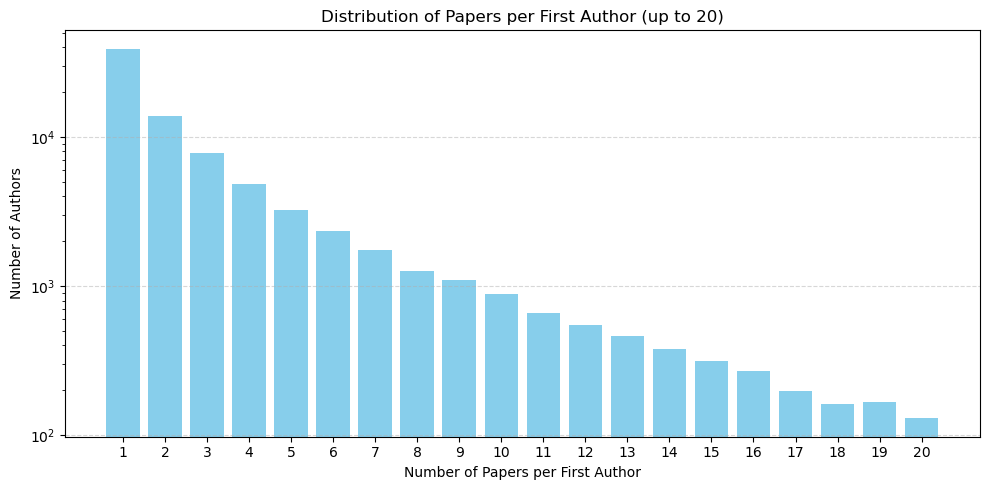

In [15]:
author_pub_counts = all_data_ref['first_author'].value_counts()
# Limit to authors with up to 20 papers
max_pubs = 20
pub_bins = range(1, max_pubs + 2)  # +2 to include 20
pub_distribution = author_pub_counts.value_counts().sort_index()
pub_distribution = pub_distribution.loc[pub_distribution.index <= max_pubs]

# Ensure all bins from 1 to 20 are included
pub_distribution = pub_distribution.reindex(range(1, max_pubs + 1), fill_value=0)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(pub_distribution.index, pub_distribution.values, color='skyblue')
plt.xticks(range(1, max_pubs + 1))
plt.xlabel('Number of Papers per First Author')
plt.ylabel('Number of Authors')
plt.title('Distribution of Papers per First Author (up to 20)')
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"figures/first_author_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
top_journals['count'].sum()/all_data_ref.shape[0]

0.6176159179319864

In [17]:
def add_reference_journal_columns(df, ref_col='reference_journal_counts', journal_list=None):
    """
    For each journal in `journal_list`, creates a new column in the DataFrame with the count
    of references to that journal from the dictionary column `ref_col`.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        ref_col (str): Name of the column containing dictionaries of journal reference counts.
        journal_list (list): List of journal names to extract counts for.

    Returns:
        pd.DataFrame: DataFrame with new columns added for each journal reference count.
    """
    if journal_list is None:
        raise ValueError("You must provide a list of journal names to extract.")

    for journal in journal_list:
        col_name = f"{journal}_ref_count"
        df[col_name] = df[ref_col].apply(
            lambda d: d.get(journal, 0) if isinstance(d, dict) else 0
        )

    return df


In [18]:
astro_top_journal_list = top_journals['journal'].tolist() + ['Sci', 'Natur', 'NatAs']


# Assuming unique_top_journals_plus_sci is your list of 33 journals
all_data_ref = add_reference_journal_columns(
    all_data_ref,
    ref_col='reference_journal_counts',
    journal_list=astro_top_journal_list
)


In [19]:
all_data_ref_clean= all_data_ref[all_data_ref['first_author_aff_country_final_valid'] == all_data_ref['first_author_aff_country_final_valid']]
all_data_ref_clean.shape

(240457, 23)

In [20]:
def compute_mean_author_journal_fraction_multi(df, journal_list, keyword="ALL",
                                               author_col='first_author',
                                               affil_col='first_author_aff_country_final_valid',
                                               keyword_col='grouped_keywords',
                                               journal_col='journal'):
    """
    Computes mean and std of per-author fraction of papers published in each journal in journal_list.
    
    Parameters:
        df (pd.DataFrame): The full dataset.
        journal_list (list of str): Journals to evaluate (e.g., ['ApJ', 'A&A']).
        keyword (str): Keyword to filter rows by df[keyword_col]; use "ALL" for no filtering.
        author_col (str): Column with first author name.
        affil_col (str): Column with first author affiliation or country.
        keyword_col (str): Column with keyword category.
        journal_col (str): Column with journal name.

    Returns:
        pd.DataFrame: With columns ['journal', 'mean_author_journal_fraction', 'median_author_journal_fraction', 'std_author_journal_fraction', 'n_authors']
    """
    # Optional keyword filtering
    if keyword != "ALL":
        df = df[df[keyword_col] == keyword]

    # Drop missing author or affiliation
    df = df[df[author_col].notna() & df[affil_col].notna()]

    # Group by author+affiliation and journal
    author_journal_counts = df.groupby([author_col, affil_col, journal_col]).size().unstack(fill_value=0)

    # Total publications per author
    author_total_counts = author_journal_counts.sum(axis=1)

    results = []

    for journal_name in journal_list:
        if journal_name not in author_journal_counts.columns:
            results.append({
                'journal': journal_name,
                'mean_author_journal_fraction': None,
                'std_author_journal_fraction': None,
                'n_authors': 0
            })
            continue

        fractions = author_journal_counts[journal_name] / author_total_counts

        results.append({
            'journal': journal_name,
            'mean_author_journal_fraction': fractions.mean(),
            'median_author_journal_fraction': fractions.median(),
            'std_author_journal_fraction': fractions.std(),
            'n_authors': fractions.count()
        })

    return pd.DataFrame(results)

journals = astro_top_journal_list
df_all_authors = compute_mean_author_journal_fraction_multi(all_data_ref, journals, keyword="ALL")


In [21]:
#all_data_ref_clean[all_data_ref_clean.first_author == 'Font, José A.']
#all_data_ref_clean[all_data_ref_clean.journal == 'PhRvD']

In [22]:
class JournalReferenceAnalyzer:
    def __init__(self, df, keyword_col='grouped_keywords', journal_col='journal'):
        self.df = df
        self.keyword_col = keyword_col
        self.journal_col = journal_col

    def journal_fraction_in_references(self, keyword_list, journal_name):
        journal_ref_col = f"{journal_name}_ref_count"
        results = []

        for keyword in keyword_list:
            if keyword == 'ALL':
                sub_df = self.df.copy()
            else:
                sub_df = self.df[self.df[self.keyword_col].str.contains(keyword)]  # 👈 filter by keyword
            sub_df = sub_df[sub_df['n_references'] > 0]

            n_articles_total = len(sub_df)

            if journal_ref_col in sub_df.columns and n_articles_total > 0:
                ref_fractions = sub_df[journal_ref_col] / sub_df['n_references']
                overall_fraction = ref_fractions.mean()
                overall_std = ref_fractions.std()
                overall_sem = overall_std / np.sqrt(n_articles_total)
            else:
                overall_fraction = None
                overall_std = None
                overall_sem = None

            sub_sub_df = sub_df[sub_df[self.journal_col] == journal_name]
            n_articles_from_journal = len(sub_sub_df)
            f_of_journal_field = (n_articles_from_journal / n_articles_total) if n_articles_total > 0 else None
            sem_f_of_journal_field = (np.sqrt(f_of_journal_field * (1 - f_of_journal_field) / n_articles_total)
                                      if f_of_journal_field is not None and n_articles_total > 0 else None)

            if journal_ref_col in sub_sub_df.columns and n_articles_from_journal > 0:
                ref_fractions_sub = sub_sub_df[journal_ref_col] / sub_sub_df['n_references']
                subset_fraction = ref_fractions_sub.mean()
                subset_std = ref_fractions_sub.std()
                subset_sem = subset_std / np.sqrt(n_articles_from_journal)
            else:
                subset_fraction = None
                subset_std = None
                subset_sem = None

            extra = (subset_fraction / overall_fraction) if overall_fraction and subset_fraction else None

            results.append({
                'keyword': keyword,
                'journal': journal_name,
                'n_articles_total': n_articles_total,
                'n_articles_from_journal': n_articles_from_journal,
                'f_of_journal_field': f_of_journal_field,
                'sem_f_of_journal_field': sem_f_of_journal_field,
                'mean_f_all_articles': overall_fraction,
                'std_f_all_articles': overall_std,
                'sem_f_all_articles': overall_sem,
                'mean_f_from_journal': subset_fraction,
                'std_f_from_journal': subset_std,
                'sem_f_from_journal': subset_sem,
                'journal_extra_citation_field': extra
            })

        return pd.DataFrame(results)

    def author_based_reference_bias(self, keyword, journal_name, match_on_name_only=False):
        journal_ref_col = f"{journal_name}_ref_count"

        if keyword == 'ALL':
            sub_df = self.df[self.df[self.journal_col] == journal_name]
        else:
            sub_df = self.df[(self.df[self.keyword_col].str.contains(keyword)) &
                             (self.df[self.journal_col] == journal_name)]

        if match_on_name_only:
            author_keys = set(sub_df['first_author'].dropna())
            author_mask = self.df['first_author'].isin(author_keys)
        else:
            author_keys = set(zip(sub_df['first_author'],
                                  sub_df['first_author_aff_country_final_valid']))
            author_mask = self.df.apply(
                lambda row: (row['first_author'], row['first_author_aff_country_final_valid']) in author_keys,
                axis=1
            )

        author_articles = self.df[author_mask].copy()
        if keyword != 'ALL':
            author_articles = author_articles[author_articles[self.keyword_col].str.contains(keyword)]
        author_articles = author_articles[author_articles['n_references'] > 0]

        if journal_ref_col not in author_articles.columns or author_articles.empty:
            return pd.DataFrame([{
                "keyword": keyword,
                "journal": journal_name,
                "n_articles_total": 0,
                "n_in_journal": 0,
                "n_outside_journal": 0,
                "mean_f_in_journal": None,
                "std_f_in_journal": None,
                "sem_f_in_journal": None,
                "mean_f_outside_journal": None,
                "std_f_outside_journal": None,
                "sem_f_outside_journal": None,
                "journal_extra_citation": None
            }]), pd.DataFrame(), pd.DataFrame()

        author_articles['ref_fraction'] = author_articles[journal_ref_col] / author_articles['n_references']

        in_journal = author_articles[author_articles[self.journal_col] == journal_name]
        outside_journal = author_articles[author_articles[self.journal_col] != journal_name]

        mean_in = in_journal['ref_fraction'].mean()
        std_in = in_journal['ref_fraction'].std()
        sem_in = std_in / np.sqrt(len(in_journal)) if len(in_journal) > 0 else None

        mean_out = outside_journal['ref_fraction'].mean()
        std_out = outside_journal['ref_fraction'].std()
        sem_out = std_out / np.sqrt(len(outside_journal)) if len(outside_journal) > 0 else None

        extra = mean_in / mean_out if pd.notna(mean_in) and pd.notna(mean_out) and mean_out != 0 else None

        result_df = pd.DataFrame([{
            "keyword": keyword,
            "journal": journal_name,
            "n_articles_total": len(author_articles),
            "n_in_journal": len(in_journal),
            "n_outside_journal": len(outside_journal),
            "mean_f_in_journal": mean_in,
            "std_f_in_journal": std_in,
            "sem_f_in_journal": sem_in,
            "mean_f_outside_journal": mean_out,
            "std_f_outside_journal": std_out,
            "sem_f_outside_journal": sem_out,
            "journal_extra_citation": extra
        }])

        return result_df, in_journal, outside_journal

    def compare_field_and_author_bias(self, keyword, journal_list, match_on_name_only=False):
        summary_rows = []

        for journal in journal_list:
            field_df = self.journal_fraction_in_references([keyword], journal_name=journal)
            field_row = field_df.iloc[0] if not field_df.empty else {}

            author_df, _, _ = self.author_based_reference_bias(
                keyword,
                journal,
                match_on_name_only=match_on_name_only  # 👈 pass the flag here
            )
            author_row = author_df.iloc[0] if not author_df.empty else {}

            summary_rows.append({
                'keyword': keyword,
                'journal': journal,

                # Field-level
                'n_articles_total': field_row.get('n_articles_total'),
                'n_articles_from_journal': field_row.get('n_articles_from_journal'),
                'f_of_journal_field': field_row.get('f_of_journal_field'),
                'sem_f_of_journal_field': field_row.get('sem_f_of_journal_field'),
                'mean_f_all_articles': field_row.get('mean_f_all_articles'),
                'std_f_all_articles': field_row.get('std_f_all_articles'),
                'sem_f_all_articles': field_row.get('sem_f_all_articles'),
                'mean_f_from_journal': field_row.get('mean_f_from_journal'),
                'std_f_from_journal': field_row.get('std_f_from_journal'),
                'sem_f_from_journal': field_row.get('sem_f_from_journal'),
                'journal_extra_citation_field': field_row.get('journal_extra_citation_field'),

                # Author-level
                'n_articles_total_author': author_row.get('n_articles_total'),
                'n_in_journal_author': author_row.get('n_in_journal'),
                'n_outside_journal_author': author_row.get('n_outside_journal'),
                'mean_f_in_journal_author': author_row.get('mean_f_in_journal'),
                'std_f_in_journal_author': author_row.get('std_f_in_journal'),
                'sem_f_in_journal_author': author_row.get('sem_f_in_journal'),
                'mean_f_outside_journal_author': author_row.get('mean_f_outside_journal'),
                'std_f_outside_journal_author': author_row.get('std_f_outside_journal'),
                'sem_f_outside_journal_author': author_row.get('sem_f_outside_journal'),
                'journal_extra_citation_author': author_row.get('journal_extra_citation'),
            })

        return pd.DataFrame(summary_rows)


    def display_summary(self, df, decimals=3):
        return df.round(decimals)


In [23]:
from statsmodels.stats.proportion import proportion_confint

# Inputs:
# k = number of successes (e.g. articles in ApJ)
# n = total number of trials (e.g. all articles in Astronomy)
# method = 'wilson', 'agresti_coull', 'jeffreys', 'beta', 'binom_test', etc.
k = 50315
n = 175709
low, high = proportion_confint(count=k, nobs=n, alpha=0.32, method='wilson')
print (low, high)

0.28528288371306626 0.2874278059286713


In [24]:
def plot_journal_contributions_and_bias(comparison_df, years = '5_years', title = None, keyword = None):
    """
    Plots journal contributions to the field and citation bias metrics.
    
    Parameters:
        comparison_df (pd.DataFrame): DataFrame with columns:
            'journal', 'f_of_journal_field', 
            'mean_f_all_articles', 'mean_f_in_journal_author', 'mean_f_outside_journal_author'
    """
    # Prepare data
    journals = comparison_df["journal"].tolist()
    fractions = comparison_df["f_of_journal_field"].tolist()
    total = sum(fractions)
    other = 1 - total
    journals_with_other = journals # + ["Other"]
    fractions_with_other = fractions # + [other]

    # Compute citation-to-field ratios
    ratios_all = (comparison_df["mean_f_all_articles"] / comparison_df["f_of_journal_field"]).tolist()
    ratios_in = (comparison_df["mean_f_in_journal_author"] / comparison_df["f_of_journal_field"]).tolist()
    ratios_out = (comparison_df["mean_f_outside_journal_author"] / comparison_df["f_of_journal_field"]).tolist()


    plt.rcdefaults()  # Resets all rcParams to their default values
    # Plot setup
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Bar plot for field contribution
    #
    # Adjust bar positions
    bar_width = 0.7
    bars = ax1.bar(journals_with_other, fractions_with_other, width=bar_width, color='skyblue', label='Field Contribution')

    ax1.set_ylabel('Fraction of Articles in Field', fontsize=13, weight='bold')
    ax1.set_xlabel('Journal', fontsize=13, weight='bold')
    ax1.set_title(title, fontsize=12)
    ax1.set_xlim(-0.5, len(journals_with_other) - 0.5)
    ax1.set_ylim(0, max(fractions_with_other)*1.3)

    for bar in bars:
        height = bar.get_height()
        #ax1.annotate(f"{height:.3f}", xy=(bar.get_x() + bar.get_width() / 3, height),
        #             xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

    # Twin axis for citation lines
    ax2 = ax1.twinx()
    ax2.set_ylim(ax1.get_ylim())

    x_ticks = range(len(comparison_df))

    line1 = ax2.plot(x_ticks, comparison_df["mean_f_all_articles"], marker='o', color='black', label='Reference Fraction')
    #line2 = ax2.plot(x_ticks, comparison_df["mean_f_in_journal_author"], marker='s', color='green', label='In-Journal Articles')
    #line3 = ax2.plot(x_ticks, comparison_df["mean_f_outside_journal_author"], marker='^', color='red', label='Outside-Journal Articles')
    ax2.set_ylabel('Mean Citation Fraction', fontsize=12)

    # Annotate ratios
    for i, x in enumerate(x_ticks):
        ax2.annotate(f"{ratios_all[i]:.2f}×", xy=(x, comparison_df["mean_f_all_articles"].iloc[i]),
                     xytext=(8, 10), textcoords="offset points", ha='center', color='black', fontsize=9)
        #ax2.annotate(f"{ratios_in[i]:.1f}×", xy=(x, comparison_df["mean_f_in_journal_author"].iloc[i]),
        #             xytext=(10, 6), textcoords="offset points", ha='center', color='green', fontsize=9)
        #ax2.annotate(f"{ratios_out[i]:.1f}×", xy=(x, comparison_df["mean_f_outside_journal_author"].iloc[i]),
        #             xytext=(0, 6), textcoords="offset points", ha='center', color='red', fontsize=9)

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.savefig(f"figures/journal_contributions_bias_{years}_{keyword}.png", dpi=300, bbox_inches='tight')  # or .pdf
    #plt.show()
    plt.close()


In [25]:
def plot_journal_citation_bias_ratios(comparison_df, years='all', title = None, keyword = None):
    """
    Visualizes citation bias ratios for each journal:
    - Green line: Mean % of references to the journal when published IN that journal,
                  divided by the mean % of references in the whole field (In-Journal / Field)
    - Red line:   Mean % of references to the journal when published IN that journal,
                  divided by the mean % when published elsewhere by the same first author
                  (In-Journal / Outside-Journal)

    Parameters:
        comparison_df (pd.DataFrame): Must contain 'journal', 'mean_f_all_articles',
                                      'mean_f_in_journal_author', 'mean_f_outside_journal_author'.
        years (str): Optional label for saving the figure filename.
    """
    journals = comparison_df['journal'].tolist()
    x = list(range(len(journals)))

    # Compute ratios
    mean_f_all = comparison_df['mean_f_all_articles']
    mean_f_in = comparison_df['mean_f_in_journal_author']
    mean_f_out = comparison_df['mean_f_outside_journal_author']

    ratio_in_field = mean_f_in / mean_f_all
    ratio_in_out = mean_f_in / mean_f_out

    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot lines with markers and styling
    ax.plot(x, ratio_in_field, marker='o', color='green', linewidth=2.5, label='In-Journal / Field')
    ax.plot(x, ratio_in_out, marker='s', color='crimson', linewidth=2.5, label='Same author: In-Journal / Outside-Journal')

    # Axis formatting
    ax.set_xticks(x)
    ax.set_xticklabels(journals, fontsize=12)
    ax.set_xlabel('Journal', fontsize=13, weight='bold')
    ax.set_ylabel('Citation Bias Factor', fontsize=13, weight='bold')
    ax.set_title(title, fontsize=14)
    ax.axhline(1.0, color='gray', linestyle='--', linewidth=1)
    ax.text(len(journals) - 2, 1.02, "No bias", color='gray', fontsize=12, ha='right', va='bottom')


    # Annotate values
    for i, xval in enumerate(x):
        if not pd.isna(ratio_in_field.iloc[i]):
            ax.annotate(f"{ratio_in_field.iloc[i]:.1f}×", (xval, ratio_in_field.iloc[i]),
                        textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, color='green')
        if not pd.isna(ratio_in_out.iloc[i]):
            ax.annotate(f"{ratio_in_out.iloc[i]:.1f}×", (xval, ratio_in_out.iloc[i]),
                        textcoords="offset points", xytext=(0, -15), ha='center', fontsize=9, color='crimson')

    ax.set_ylim(0.5, max(ratio_in_field.max(), ratio_in_out.max()) * 1.1)  # Adjust y-limits for better visibility
    # Optional grid and styling
    #ax.grid(True, axis='y', linestyle=':', linewidth=0.7)
    ax.legend(loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/journal_citation_bias_ratios_{years}_{keyword}.png", dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close()

In [26]:
all_data_ref_clean_5 = all_data_ref_clean[all_data_ref_clean['year'] >= 2020]
all_data_ref_clean_10 = all_data_ref_clean[all_data_ref_clean['year'] >= 2015]


# Define your journal list
journal_list = astro_top_journal_list  # or replace with your actual list

# ALL years
analyzer_all = JournalReferenceAnalyzer(all_data_ref_clean, keyword_col='my_keyword')
comparison_df_all = analyzer_all.compare_field_and_author_bias(
    keyword="ALL",
    journal_list=journal_list,
    match_on_name_only=False
)

# Last 10 years
analyzer_10 = JournalReferenceAnalyzer(all_data_ref_clean_10, keyword_col='my_keyword')
comparison_df_10 = analyzer_10.compare_field_and_author_bias(
    keyword="ALL",
    journal_list=journal_list,
    match_on_name_only=False
)

# Last 5 years
analyzer_5 = JournalReferenceAnalyzer(all_data_ref_clean_5, keyword_col='my_keyword')
comparison_df_5 = analyzer_5.compare_field_and_author_bias(
    keyword="ALL",
    journal_list=journal_list,
    match_on_name_only=False
)

In [27]:

plot_journal_citation_bias_ratios(comparison_df_all, years='ALL', title = r'Field: $\it{Astronomy}$; Years: 2000-2025', keyword = 'Astronomy')
plot_journal_contributions_and_bias(comparison_df_all, years = 'ALL', title = r'Field: $\it{Astronomy}$; Years: 2000-2025', keyword = 'Astronomy')

plot_journal_citation_bias_ratios(comparison_df_10, years='10_years', title = r'Field: $\it{Astronomy}$; Years: 2015-2025', keyword = 'Astronomy')
plot_journal_contributions_and_bias(comparison_df_10, years = '10_years', title = r'Field: $\it{Astronomy}$; Years: 2015-2025', keyword = 'Astronomy')

plot_journal_citation_bias_ratios(comparison_df_5, years='5_years', title = r'Field: $\it{Astronomy}$; Years: 2020-2025', keyword = 'Astronomy')
plot_journal_contributions_and_bias(comparison_df_5, years = '5_years', title = r'Field: $\it{Astronomy}$; Years: 2020-2025', keyword = 'Astronomy')

summary_df_display = comparison_df_all.round(3)
summary_df_display


,keyword,journal,n_articles_total,n_articles_from_journal,f_of_journal_field,sem_f_of_journal_field,mean_f_all_articles,std_f_all_articles,sem_f_all_articles,mean_f_from_journal,...,n_articles_total_author,n_in_journal_author,n_outside_journal_author,mean_f_in_journal_author,std_f_in_journal_author,sem_f_in_journal_author,mean_f_outside_journal_author,std_f_outside_journal_author,sem_f_outside_journal_author,journal_extra_citation_author
0,ALL,ApJ,240457,64158,0.267,0.001,0.289,0.170,0.0,0.408,...,110719,64158,46561,0.408,0.136,0.001,0.317,0.150,0.001,1.287
1,ALL,MNRAS,240457,50749,0.211,0.001,0.143,0.132,0.0,0.258,...,95426,50749,44677,0.258,0.141,0.001,0.160,0.120,0.001,1.614
2,ALL,A&A,240457,38555,0.160,0.001,0.132,0.119,0.0,0.257,...,63474,38555,24919,0.257,0.132,0.001,0.173,0.118,0.001,1.485
3,ALL,Sci,240457,455,0.002,0.000,0.007,0.021,0.0,0.044,...,2809,455,2354,0.044,0.072,0.003,0.018,0.031,0.001,2.437
4,ALL,Natur,240457,1240,0.005,0.000,0.018,0.034,0.0,0.100,...,7036,1240,5796,0.100,0.131,0.004,0.030,0.040,0.001,3.339
5,ALL,NatAs,240457,687,0.003,0.000,0.002,0.007,0.0,0.016,...,3600,687,2913,0.016,0.031,0.001,0.005,0.013,0.000,2.964


In [28]:
import numpy as np

def sample_reference_fraction(df, j_name, n, repeats=3, random_state=None):
    """
    Randomly samples `n` articles with a given journal name and calculates the mean
    fraction of references that cite the same journal. Repeats this sampling multiple
    times and returns the overall mean and standard deviation.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        j_name (str): Journal name to filter and check in reference counts.
        n (int): Number of articles to randomly select each time.
        repeats (int): Number of repetitions for averaging.
        random_state (int, optional): Seed for reproducibility.

    Returns:
        dict: {
            'mean_fraction': mean of average reference fractions,
            'std_fraction': standard deviation of those means,
            'individual_means': list of mean fractions from each repetition
        }
    """
    results = []

    for i in range(repeats):
        rs = None if random_state is None else random_state + i
        sample_df = df[df['journal'] == j_name].sample(n=n, random_state=rs)

        fractions = []
        for _, row in sample_df.iterrows():
            ref_counts = row.get('reference_journal_counts', {})
            n_refs = row.get('n_references', 0)

            if isinstance(ref_counts, dict) and n_refs > 0:
                f = ref_counts.get(j_name, 0) / n_refs
                fractions.append(f)

        if fractions:
            results.append(np.mean(fractions))

    return {
        'mean_fraction': np.mean(results) if results else None,
        'std_fraction': np.std(results) if results else None,
        #'individual_means': results
    }

result = sample_reference_fraction(all_data_ref_clean, j_name='A&A', n=50, repeats=5, random_state=123)
print(result)


{'mean_fraction': 0.2582519013278895, 'std_fraction': 0.012572256908734146}


In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure figures folder exists
os.makedirs("figures", exist_ok=True)

def compute_bias_ratios(comparison_df, label="ALL"):
    """
    Computes citation bias ratios for each journal.

    Returns a DataFrame with:
    - journal
    - in_field_ratio: mean_f_in_journal_author / mean_f_all_articles
    - in_outside_ratio: mean_f_in_journal_author / mean_f_outside_journal_author
    - label: source name (e.g. 'ALL', '5_years')
    """
    journals = comparison_df['journal']
    mean_f_all = comparison_df['mean_f_all_articles']
    mean_f_in = comparison_df['mean_f_in_journal_author']
    mean_f_out = comparison_df['mean_f_outside_journal_author']

    ratio_in_field = mean_f_in / mean_f_all
    ratio_in_out = mean_f_in / mean_f_out

    return pd.DataFrame({
        'journal': journals,
        'in_field_ratio': ratio_in_field,
        'in_outside_ratio': ratio_in_out,
        'label': label
    })

def plot_precomputed_journal_bias_ratios_flexible(bias_dfs, labels, keyword='Astronomy'):
    """
    Plots citation bias ratios (in/field and in/out) for any number of precomputed DataFrames.

    Parameters:
        bias_dfs (list of pd.DataFrame): List of precomputed bias DataFrames (with in_field_ratio, in_outside_ratio)
        labels (list of str): Labels corresponding to each DataFrame (e.g., ['ALL', '10y'])
        keyword (str): Used for plot title and filename.
    """
    assert len(bias_dfs) == len(labels), "Each DataFrame must have a corresponding label."

    journals = bias_dfs[0]['journal'].tolist()
    x = list(range(len(journals)))

    fig, ax = plt.subplots(figsize=(8, 5))

    line_styles = ['solid', 'dashed', 'dotted', 'dashdot']
    colors = {'in/field': 'green', 'in/out': 'crimson'}

    for i, (df, label) in enumerate(zip(bias_dfs, labels)):
        style = line_styles[i % len(line_styles)]
        is_all = (label == '25yrs')
        alpha_val = 1.0 if is_all else 0.3

        ax.plot(x, df['in_field_ratio'], linestyle=style, color=colors['in/field'], linewidth=2.5,
                marker='o', label='In-Journal / Field' if is_all else None, alpha=alpha_val, zorder=0)
        ax.plot(x, df['in_outside_ratio'], linestyle=style, color=colors['in/out'], linewidth=2.5,
                marker='s', label='In-Journal / Outside' if is_all else None, alpha=alpha_val, zorder=0)

        # Add inline label to the last point
        if not df['in_field_ratio'].isna().all():
            ax.text(x[-1] + 0.15, df['in_field_ratio'].iloc[-1], f"{label}", fontsize=10,
                    color=colors['in/field'], va='center', alpha=alpha_val)

        if not df['in_outside_ratio'].isna().all():
            ax.text(x[-1] + 0.15, df['in_outside_ratio'].iloc[-1], f"{label}", fontsize=10,
                    color=colors['in/out'], va='center', alpha=alpha_val)


        # Annotate only for first (ALL) dataset
        if is_all:
            for j in range(len(journals)):
                val1 = df['in_field_ratio'].iloc[j]
                val2 = df['in_outside_ratio'].iloc[j]
                if pd.notna(val1):
                    ax.annotate(f"{val1:.1f}×", (j, val1), xytext=(-2, 10),
                                textcoords="offset points", ha='center', fontsize=9, color=colors['in/field'], weight='bold', zorder=1)
                if pd.notna(val2):
                    ax.annotate(f"{val2:.1f}×", (j, val2), xytext=(-2, -12),
                                textcoords="offset points", ha='center', fontsize=9, color=colors['in/out'], weight='bold',  zorder=1)


    from matplotlib.lines import Line2D
    custom_legend = [
        Line2D([0], [0], marker='o', linestyle='None', markerfacecolor='green', color='green',
            markersize=8, label='In-Journal / Field'),
        Line2D([0], [0], marker='s', linestyle='None', markerfacecolor='crimson', color='crimson',
            markersize=8, label='In-Journal / Out-journal')
    ]
    ax.legend(handles=custom_legend, loc='upper left', fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(journals, fontsize=13)  # No rotation
    ax.set_xlabel('Journal', fontsize=13, weight='bold')
    ax.set_ylabel('Citation Bias Factor', fontsize=13, weight='bold')
    ax.tick_params(axis='y', labelsize=12)
    #ax.set_title(f'Citation Bias in the {keyword} Field', fontsize=14)

    ax.axhline(1.0, color='gray', linestyle='--', linewidth=1)
    ax.text(len(journals) - 2.5, 1.02, "No bias", color='gray', fontsize=13, ha='right')

    # Adjust y-limit
    ymax = max(df[['in_field_ratio', 'in_outside_ratio']].max().max() for df in bias_dfs)
    ax.set_ylim(0.5, ymax * 1.1)
    ax.set_xlim(-0.2, len(journals) -0.5 )


    #ax.legend(loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/journal_bias_curves_{keyword}.png", dpi=300, bbox_inches='tight')
    plt.show()



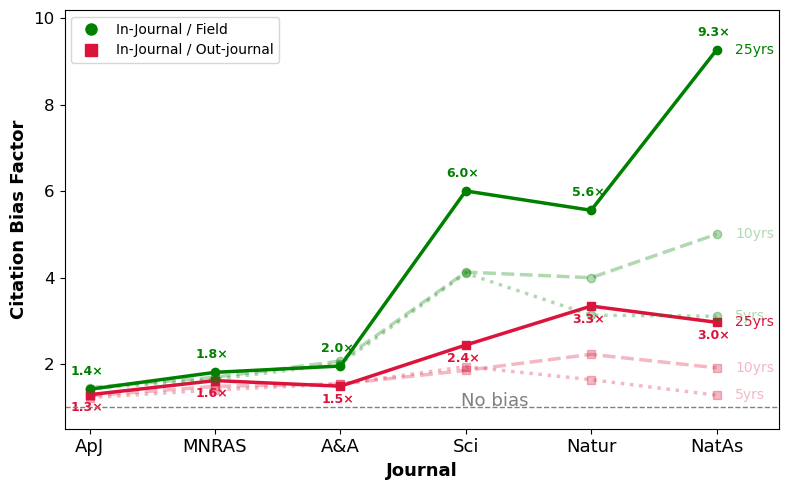

In [30]:
bias_all = compute_bias_ratios(comparison_df_all, label='ALL')
bias_5 = compute_bias_ratios(comparison_df_5, label='5_years')
bias_10 = compute_bias_ratios(comparison_df_10, label='10_years')

plot_precomputed_journal_bias_ratios_flexible(
    bias_dfs=[bias_all, bias_10, bias_5],
    labels=['25yrs', '10yrs', '5yrs'],
    keyword='Astronomy'
)


In [31]:
all_data_ref_clean[all_data_ref_clean.journal == 'A&A'].citation_count.mean()

41.8480871482298

In [32]:
for journal in astro_top_journal_list:
    mean_citations = all_data_ref_clean[all_data_ref_clean.journal == journal].citation_count.mean()
    mean_age = 2025- all_data_ref_clean[all_data_ref_clean.journal == journal].year.mean()
    print(journal, mean_citations, mean_age)

ApJ 57.26102746344961 11.595295988029648
MNRAS 43.57396204851327 9.45904352795128
A&A 41.8480871482298 11.647775904551963
Sci 204.75384615384615 14.272527472527372
Natur 155.7258064516129 11.941129032258004
NatAs 56.6608442503639 4.388646288209657


In [33]:
all_data_ref_clean_30references = all_data_ref_clean[all_data_ref_clean.n_references < 30]
all_data_ref_clean_30references.shape

(50663, 23)

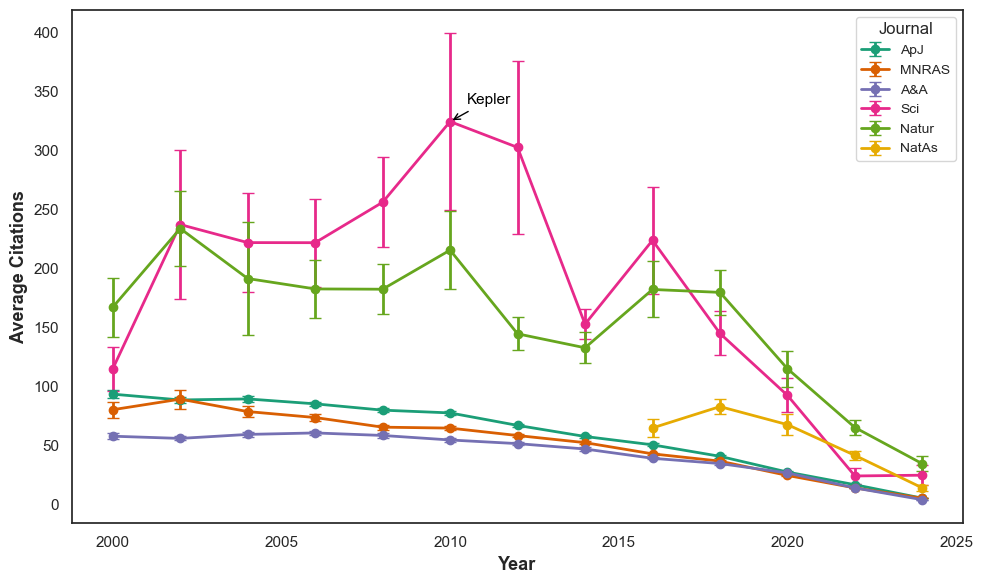

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure figures folder exists
os.makedirs("figures", exist_ok=True)

def compute_avg_citations_per_year_bins(
    df, journal_list, bin_size=1, year_col='year', citation_col='citation_count', journal_col='journal'
):
    results = []

    for journal in journal_list:
        sub_df = df[df[journal_col] == journal].copy()
        sub_df['year_bin'] = (sub_df[year_col] // bin_size) * bin_size

        grouped = sub_df.groupby('year_bin')[citation_col].agg(['mean', 'std', 'count']).reset_index()
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped.rename(columns={'mean': 'avg_citations', 'sem': 'sem_citations'}, inplace=True)
        grouped['journal'] = journal
        results.append(grouped[['year_bin', 'avg_citations', 'sem_citations', 'journal']])

    return pd.concat(results, ignore_index=True)

def plot_avg_citations_over_time_seaborn(avg_citation_df, keyword='Astronomy', x_col='year_bin'):
    sns.set_theme(style='white', context='notebook')
    plt.figure(figsize=(10, 6))

    palette = sns.color_palette('Dark2', n_colors=avg_citation_df['journal'].nunique())

    for i, journal in enumerate(avg_citation_df['journal'].unique()):
        sub = avg_citation_df[avg_citation_df['journal'] == journal]
        plt.errorbar(
            sub[x_col], sub['avg_citations'], yerr=sub['sem_citations'],
            fmt='-o', label=journal, capsize=4, linewidth=2, color=palette[i]
        )

    # Annotate the Kepler peak (example: A&A 2014 bin)
    kepler_peak = avg_citation_df[
        (avg_citation_df['journal'] == 'Sci') &
        (avg_citation_df[x_col] == 2010)  # or adjust to 2012/2016 if binned differently
    ]
    if not kepler_peak.empty:
        x_val = kepler_peak[x_col].values[0]
        y_val = kepler_peak['avg_citations'].values[0]
        plt.annotate(
            "Kepler",
            xy=(x_val, y_val),
            xytext=(x_val + 0.5, y_val + 15),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=11,
            color='black'
        )

    plt.xlabel("Year", fontsize=13, weight='bold')
    plt.ylabel("Average Citations", fontsize=13, weight='bold')
    #plt.title(f"Average Citation Count per Period ({keyword})", fontsize=15)
    plt.legend(title='Journal', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/avg_citations_by_{x_col}_{keyword}_seaborn.png", dpi=300)
    plt.show()

Kepler = all_data_ref_clean[~all_data_ref_clean['title'].str.contains('Kepler', case=False, na=False)]
# Example usage:
avg_cit_df_2y = compute_avg_citations_per_year_bins(
    df=all_data_ref_clean,
    journal_list=astro_top_journal_list,
    bin_size=2
)

plot_avg_citations_over_time_seaborn(avg_cit_df_2y, keyword='Astronomy')


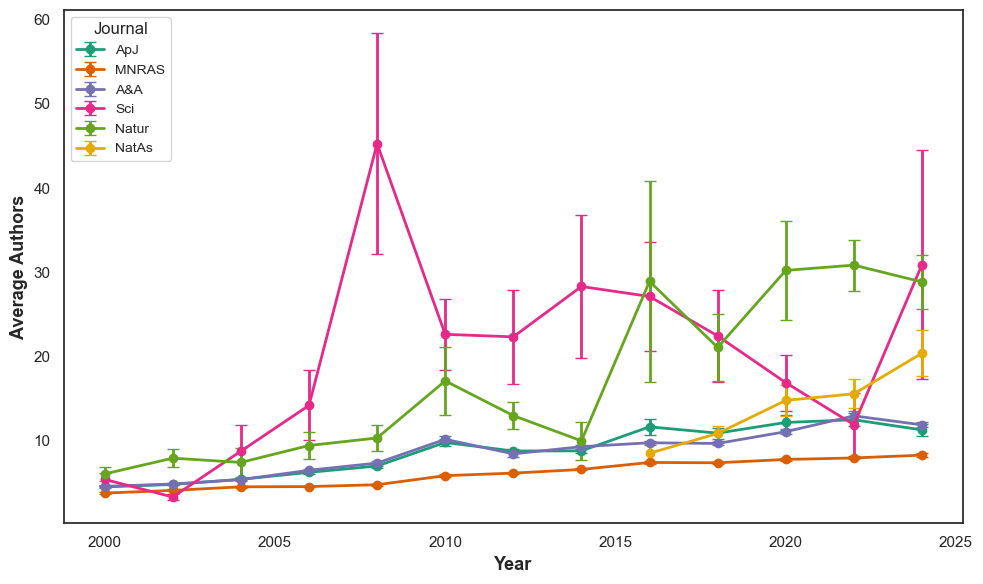

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure figures folder exists
os.makedirs("figures", exist_ok=True)

def compute_avg_authors_per_year_bins(
    df, journal_list, bin_size=1, year_col='year', citation_col='n_authors', journal_col='journal'
):
    results = []

    for journal in journal_list:
        sub_df = df[df[journal_col] == journal].copy()
        sub_df['year_bin'] = (sub_df[year_col] // bin_size) * bin_size

        grouped = sub_df.groupby('year_bin')[citation_col].agg(['mean', 'std', 'count']).reset_index()
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped.rename(columns={'mean': 'avg_citations', 'sem': 'sem_citations'}, inplace=True)
        grouped['journal'] = journal
        results.append(grouped[['year_bin', 'avg_citations', 'sem_citations', 'journal']])

    return pd.concat(results, ignore_index=True)

def plot_avg_authors_over_time_seaborn(avg_citation_df, keyword='Astronomy', x_col='year_bin'):
    sns.set_theme(style='white', context='notebook')
    plt.figure(figsize=(10, 6))

    palette = sns.color_palette('Dark2', n_colors=avg_citation_df['journal'].nunique())

    for i, journal in enumerate(avg_citation_df['journal'].unique()):
        sub = avg_citation_df[avg_citation_df['journal'] == journal]
        plt.errorbar(
            sub[x_col], sub['avg_citations'], yerr=sub['sem_citations'],
            fmt='-o', label=journal, capsize=4, linewidth=2, color=palette[i]
        )



    plt.xlabel("Year", fontsize=13, weight='bold')
    plt.ylabel("Average Authors", fontsize=13, weight='bold')
    #plt.title(f"Average Citation Count per Period ({keyword})", fontsize=15)
    plt.legend(title='Journal', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/avg_authors_by_{x_col}_{keyword}_seaborn.png", dpi=300)
    plt.show()

Kepler = all_data_ref_clean[~all_data_ref_clean['title'].str.contains('Kepler', case=False, na=False)]
# Example usage:
avg_cit_df_2y = compute_avg_authors_per_year_bins(
    df=all_data_ref_clean,
    journal_list=astro_top_journal_list,
    bin_size=2
)

plot_avg_authors_over_time_seaborn(avg_cit_df_2y, keyword='Astronomy')


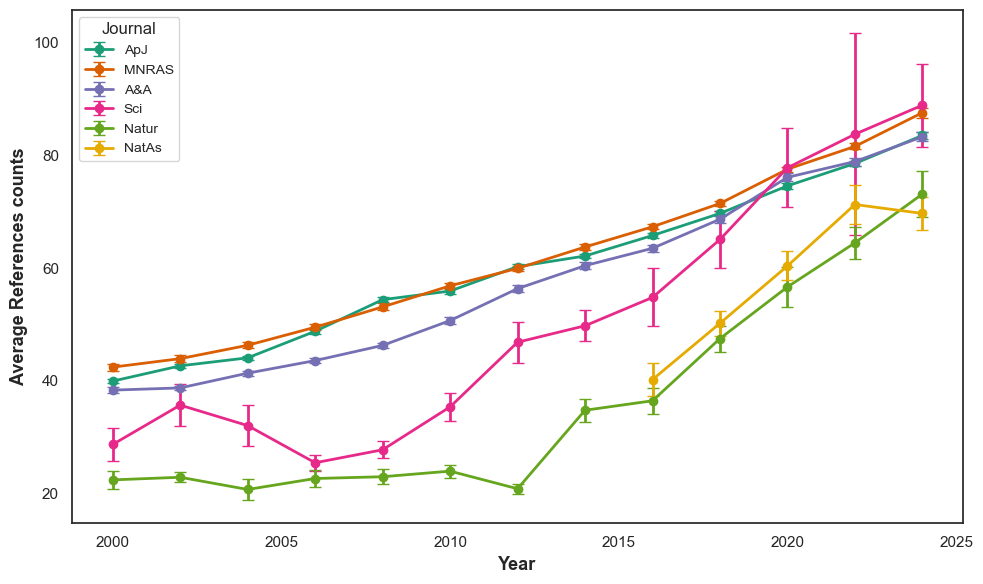

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure figures folder exists
os.makedirs("figures", exist_ok=True)

def compute_avg_referenes_per_year_bins(
    df, journal_list, bin_size=1, year_col='year', reference_col='n_references', journal_col='journal'
):
    results = []

    for journal in journal_list:
        sub_df = df[df[journal_col] == journal].copy()
        sub_df['year_bin'] = (sub_df[year_col] // bin_size) * bin_size

        grouped = sub_df.groupby('year_bin')[reference_col].agg(['mean', 'std', 'count']).reset_index()
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped.rename(columns={'mean': 'avg_citations', 'sem': 'sem_citations'}, inplace=True)
        grouped['journal'] = journal
        results.append(grouped[['year_bin', 'avg_citations', 'sem_citations', 'journal']])

    return pd.concat(results, ignore_index=True)

def plot_avg_citations_over_time_seaborn(avg_citation_df, keyword='Astronomy', x_col='year_bin'):
    sns.set_theme(style='white', context='notebook')
    plt.figure(figsize=(10, 6))

    palette = sns.color_palette('Dark2', n_colors=avg_citation_df['journal'].nunique())

    for i, journal in enumerate(avg_citation_df['journal'].unique()):
        sub = avg_citation_df[avg_citation_df['journal'] == journal]
        plt.errorbar(
            sub[x_col], sub['avg_citations'], yerr=sub['sem_citations'],
            fmt='-o', label=journal, capsize=4, linewidth=2, color=palette[i]
        )


    plt.xlabel("Year", fontsize=13, weight='bold')
    plt.ylabel("Average References counts", fontsize=13, weight='bold')
    #plt.title(f"Average Citation Count per Period ({keyword})", fontsize=15)
    plt.legend(title='Journal', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/avg_references_by_{x_col}_{keyword}_seaborn.png", dpi=300)
    plt.show()

Kepler = all_data_ref_clean[~all_data_ref_clean['title'].str.contains('Kepler', case=False, na=False)]
# Example usage:
avg_cit_df_2y = compute_avg_referenes_per_year_bins(
    df=all_data_ref_clean,
    journal_list=astro_top_journal_list,
    bin_size=2
)

plot_avg_citations_over_time_seaborn(avg_cit_df_2y, keyword='Astronomy')


'Swope Supernova Survey 2017a (SSS17a), the o...	988	2017Sci...358.1556C
all_data_ref_clean[(all_data_ref_clean.journal == 'Natur') & (all_data_ref_clean.year == 2018)][['title', 'citation_count', 'bibcode']]

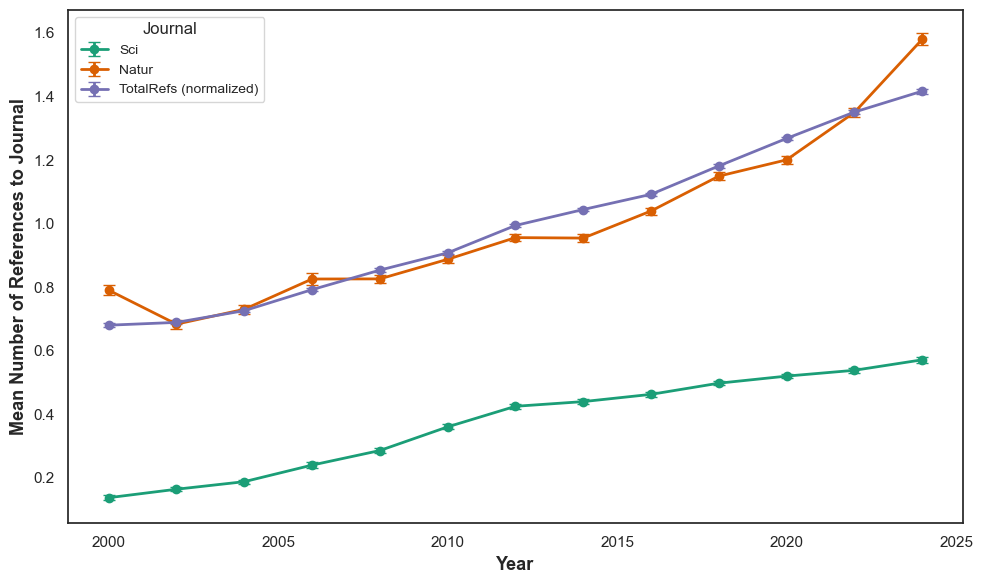

In [59]:
def compute_avg_journal_references_with_total(
    df, journal_list, bin_size=1, year_col='year', reference_col='n_references'
):
    results = []

    df = df.copy()
    df['year_bin'] = (df[year_col] // bin_size) * bin_size

    for journal in journal_list:
        col = f"{journal}_ref_count"
        if col not in df.columns:
            continue  # skip if journal not available

        grouped = df.groupby('year_bin')[col].agg(['mean', 'std', 'count']).reset_index()
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped.rename(columns={'mean': 'avg_references', 'sem': 'sem_references'}, inplace=True)
        grouped['journal'] = journal
        results.append(grouped[['year_bin', 'avg_references', 'sem_references', 'journal']])

    # Add normalized total references
    total_refs = df.groupby('year_bin')[reference_col].agg(['mean', 'std', 'count']).reset_index()
    total_refs['sem'] = total_refs['std'] / np.sqrt(total_refs['count'])
    total_refs.rename(columns={'mean': 'avg_references', 'sem': 'sem_references'}, inplace=True)
    overall_mean = total_refs['avg_references'].mean()
    total_refs['avg_references'] /= overall_mean
    total_refs['sem_references'] /= overall_mean
    total_refs['journal'] = 'TotalRefs (normalized)'

    results.append(total_refs[['year_bin', 'avg_references', 'sem_references', 'journal']])

    return pd.concat(results, ignore_index=True)


def plot_avg_journal_references_over_time(df, keyword='Astronomy', x_col='year_bin'):
    sns.set_theme(style='white', context='notebook')
    plt.figure(figsize=(10, 6))

    palette = sns.color_palette('Dark2', n_colors=df['journal'].nunique())

    for i, journal in enumerate(df['journal'].unique()):
        sub = df[df['journal'] == journal]
        plt.errorbar(
            sub[x_col], sub['avg_references'], yerr=sub['sem_references'],
            fmt='-o', label=journal, capsize=4, linewidth=2, color=palette[i]
        )

    plt.xlabel("Year", fontsize=13, weight='bold')
    plt.ylabel("Mean Number of References to Journal", fontsize=13, weight='bold')
    plt.legend(title='Journal', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/avg_reference_mentions_by_{x_col}_{keyword}.png", dpi=300)
    plt.show()

#astro_top_journal_list
journals = ['Sci', 'Natur']
ref_df = compute_avg_journal_references_with_total(all_data_ref_clean, journal_list=journals, bin_size=2)
plot_avg_journal_references_over_time(ref_df, keyword='Astronomy')



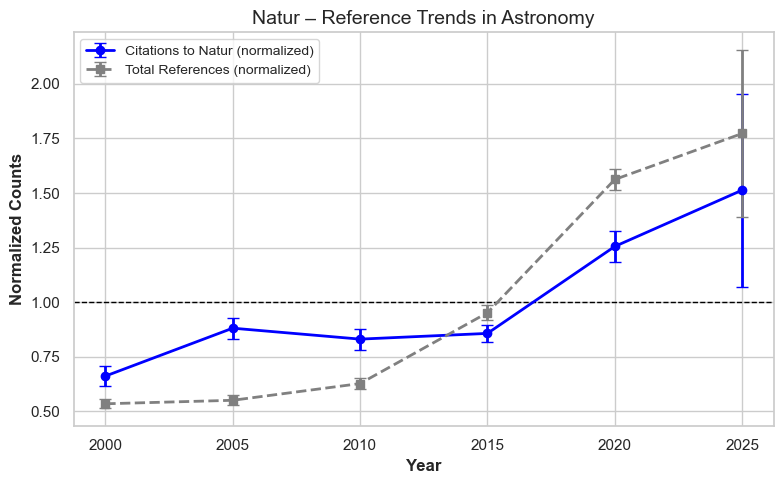

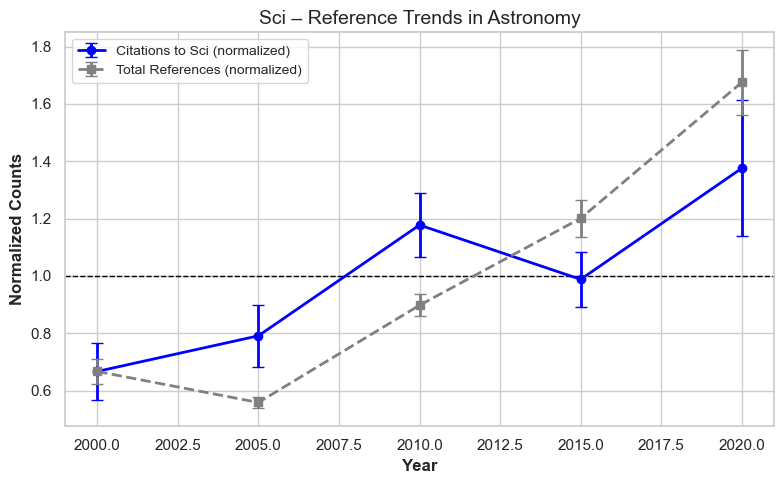

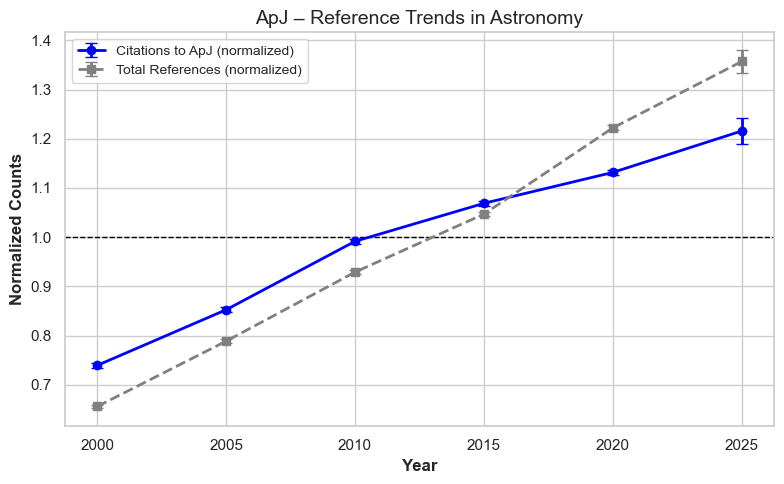

In [66]:
def compute_refcount_and_totalrefs_normalized(
    df, journal_list, bin_size=2, year_col='year', reference_col='n_references', journal_col='journal'
):
    """
    For each journal:
    - Computes average references to that journal (from *_ref_count column), normalized
    - Computes average total references in papers published in that journal, normalized
    """
    results = []

    for journal in journal_list:
        sub_df = df[df[journal_col] == journal].copy()
        sub_df['year_bin'] = (sub_df[year_col] // bin_size) * bin_size
        ref_col = f"{journal}_ref_count"

        if ref_col not in sub_df.columns:
            continue

        grouped = sub_df.groupby('year_bin').agg({
            ref_col: ['mean', 'std', 'count'],
            reference_col: ['mean', 'std']
        }).reset_index()

        # Flatten multiindex columns
        grouped.columns = ['year_bin', 'ref_mean', 'ref_std', 'count', 'nref_mean', 'nref_std']

        # SEM
        grouped['ref_sem'] = grouped['ref_std'] / np.sqrt(grouped['count'])
        grouped['nref_sem'] = grouped['nref_std'] / np.sqrt(grouped['count'])

        # Normalize both
        ref_mean_global = grouped['ref_mean'].mean()
        nref_mean_global = grouped['nref_mean'].mean()

        grouped['ref_mean_norm'] = grouped['ref_mean'] / ref_mean_global
        grouped['ref_sem_norm'] = grouped['ref_sem'] / ref_mean_global

        grouped['nref_mean_norm'] = grouped['nref_mean'] / nref_mean_global
        grouped['nref_sem_norm'] = grouped['nref_sem'] / nref_mean_global

        grouped['journal'] = journal
        results.append(grouped[['year_bin', 'ref_mean_norm', 'ref_sem_norm',
                                'nref_mean_norm', 'nref_sem_norm', 'journal']])

    return pd.concat(results, ignore_index=True)


def plot_journal_reference_counts(data, output_dir="figures", keyword="Astronomy"):
    """
    Plots normalized reference counts to each journal and normalized total references per journal.
    """
    os.makedirs(output_dir, exist_ok=True)
    sns.set_theme(style='whitegrid')

    for journal in data['journal'].unique():
        sub = data[data['journal'] == journal]

        plt.figure(figsize=(8, 5))

        # Plot normalized ref counts to the journal
        plt.errorbar(
            sub['year_bin'], sub['ref_mean_norm'], yerr=sub['ref_sem_norm'],
            fmt='-o', label=f'Citations to {journal} (normalized)', capsize=4, color='blue', linewidth=2
        )

        # Plot normalized total reference counts
        plt.errorbar(
            sub['year_bin'], sub['nref_mean_norm'], yerr=sub['nref_sem_norm'],
            fmt='--s', label='Total References (normalized)', capsize=4, color='gray', linewidth=2
        )

        plt.xlabel("Year", fontsize=12, weight='bold')
        plt.ylabel("Normalized Counts", fontsize=12, weight='bold')
        plt.title(f"{journal} – Reference Trends in {keyword}", fontsize=14)
        plt.axhline(1.0, linestyle='--', color='black', linewidth=1)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/ref_trends_{journal}_{keyword}.png", dpi=300)
        #plt.close()

journal_list = ['Natur', 'Sci', 'ApJ']

ref_trends_df = compute_refcount_and_totalrefs_normalized(
    df=all_data_ref_clean,
    journal_list=journal_list,
    bin_size=5
)

plot_journal_reference_counts(ref_trends_df, keyword='Astronomy')


In [57]:
all_data_ref_clean

,bibcode,my_keyword,title,year,abstract,first_author,n_authors,first_author_aff,first_author_aff_country_final_valid,read_count,...,n_references,journal,reference_journal_counts,author_key,ApJ_ref_count,MNRAS_ref_count,A&A_ref_count,Sci_ref_count,Natur_ref_count,NatAs_ref_count
0,2000A&A...353...25M,"AGN,Galaxy",['Soft X-ray AGN luminosity function from it R...,2000,We investigate the evolution of the 0.5-2 keV ...,"Miyaji, Takamitsu",3,Max-Planck-Inst. für extraterrestrische Physik...,Germany,18,...,56,A&A,"{'ApJ': 12, 'MNRAS': 17, 'PhR': 1, 'nrfa': 1, ...","(Miyaji, Takamitsu, Germany)",12,17,10,0,0,0
1,2000A&A...353...41S,Galaxy,['Cluster mass profiles from weak lensing: con...,2000,A massive foreground cluster lens changes the ...,"Schneider, Peter",3,"Max-Planck-Institut für Astrophysik, Postfach ...",Germany,10,...,42,A&A,"{'ApJ': 19, 'A&A': 13, 'MNRAS': 5, 'grle': 1, ...","(Schneider, Peter, Germany)",19,5,13,0,0,0
2,2000A&A...353...57G,Galaxy,['The redshift-space two-point correlation fun...,2000,We measure the two-point redshift-space correl...,"Girardi, Marisa",3,"Dipartimento di Astronomia, Università degli S...",Italy,18,...,44,A&A,"{'ApJ': 22, 'lssu': 1, 'A&A': 1, 'Sci': 1, 'NA...","(Girardi, Marisa, Italy)",22,6,1,1,0,0
3,2000A&A...353...92R,Galaxy,['Interaction rate at z ~ 1'],2000,We found 25 galaxies with probable tidal tails...,"Reshetnikov, Vladimir P.",1,Astronomical Institute of St.Petersburg State ...,Russia,16,...,43,A&A,"{'ApJ': 19, 'egsp': 1, 'dvga': 1, 'MNRAS': 5, ...","(Reshetnikov, Vladimir P., Russia)",19,5,1,0,0,0
4,2000A&A...353..117M,"Galaxy,Star",['Is the exponential distribution a good appro...,2000,We investigate how significant the spiral stru...,"Misiriotis, A.",4,"University of Crete, Physics Department, P.O. ...",France,20,...,22,A&A,"{'ApJ': 6, 'A&A': 5, 'AJ': 2, 'ApJS': 1, 'A&AS...","(Misiriotis, A., France)",6,3,5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255001,2025Univ...11...14X,Star,['A Scenario for Origin of Global 4 mHz Oscill...,2025,We establish a spherically symmetric model of ...,"Xue, Li",3,"Department of Astronomy, Xiamen Univesity, Xia...",China,403,...,61,Univ,"{'NW': 1, 'ApJ': 26, 'SoPh': 4, 'tsp': 1, 'ApJ...","(Xue, Li, China)",26,3,6,2,3,1
255002,2025Univ...11...18X,Star,['Distinguishing Compact Objects in Extreme-Ma...,2025,Extreme-mass-ratio inspirals (EMRIs) are promi...,"Xu, Lujia",6,"School of Physics and Astronomy, University of...",China,118,...,10,Univ,"{'arXiv0907': 1, 'PhRvD': 3, 'PhRvL': 2, 'gwv'...","(Xu, Lujia, China)",0,1,0,0,0,0
255003,2025Univ...11...29G,Star,"['Surface and Curvature Tensions of Cold, Dens...",2025,"In this paper, we conduct a thorough investiga...","Grunfeld, Ana Gabriela",3,"CONICET, Godoy Cruz (C1425FQB), Ciudad Autónom...",Argentina,136,...,22,Univ,"{'PhRvL': 1, 'PhR': 2, 'NuPhA': 1, 'PThPh': 1,...","(Grunfeld, Ana Gabriela, Argentina)",0,0,0,0,0,0
255005,2025Univ...11...47P,"AGN,Galaxy,Star","[""Core to Cosmic Edge: SIMBA-C's New Take on A...",2025,We employ the SIMBA-C cosmological simulation ...,"Padawer-Blatt, Aviv",12,"Department of Physics and Astronomy, Universit...",Canada,336,...,16,Univ,"{'FCPh': 1, 'SPIE': 1, 'A&A': 7, 'arXiv1207': ...","(Padawer-Blatt, Aviv, Canada)",0,0,7,0,0,0


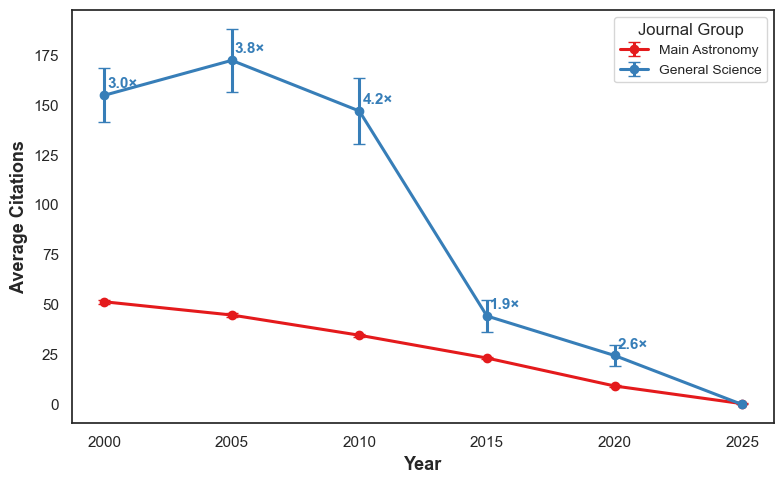

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("figures", exist_ok=True)

# Re-import necessary packages after code state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def compute_avg_citations_grouped(
    df, journal_groups, bin_size=1, year_col='year', citation_col='citation_count', journal_col='journal'
):
    """
    Computes average citation stats per group of journals, per year bin.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        journal_groups (dict): Keys are group names, values are lists of journal names.
        bin_size (int): Size of year bin (e.g. 2 = 2-year bins)
        year_col (str): Column name with year info.
        citation_col (str): Column name with citation counts.
        journal_col (str): Column name with journal names.

    Returns:
        pd.DataFrame with columns: 'group', 'year_bin', 'avg_citations', 'sem_citations'
    """
    results = []

    for group_name, journal_list in journal_groups.items():
        sub_df = df[df[journal_col].isin(journal_list)].copy()
        sub_df['year_bin'] = (sub_df[year_col] // bin_size) * bin_size
        #sub_df['year_bin'] = ((sub_df[year_col] // bin_size) * bin_size) + (bin_size // 2)

        grouped = sub_df.groupby('year_bin')[citation_col].agg(['mean', 'std', 'count']).reset_index()
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped.rename(columns={'mean': 'avg_citations', 'sem': 'sem_citations'}, inplace=True)
        grouped['group'] = group_name
        results.append(grouped[['year_bin', 'avg_citations', 'sem_citations', 'group']])

    return pd.concat(results, ignore_index=True)




def plot_avg_citations_grouped_with_ratios(df, keyword='Astronomy', x_col='year_bin'):
    """
    Plots citation trends with standard error for grouped journals.
    Annotates how much higher General Science and Nature Astronomy are compared to Main Astronomy
    for each year bin (excluding the last one).
    """
    sns.set_theme(style='white', context='notebook')
    plt.figure(figsize=(8, 5))

    unique_groups = df['group'].unique()
    palette = sns.color_palette('Set1', n_colors=len(unique_groups))
    group_colors = {group: palette[i] for i, group in enumerate(unique_groups)}

    # Annotate ratios for each bin (excluding the last)
    bins = sorted(df[x_col].unique())[:-1]
    base_group = 'Main Astronomy'


    # Plot lines
    for group_name in unique_groups:
        sub = df[df['group'] == group_name]
        plt.errorbar(
            sub[x_col], sub['avg_citations'], yerr=sub['sem_citations'],
            fmt='-o', label=group_name, capsize=4, linewidth=2.2, color=group_colors[group_name]
        )



    for b in bins:
        base_val = df[(df['group'] == base_group) & (df[x_col] == b)]['avg_citations'].values
        if len(base_val) == 0:
            continue
        base_val = base_val[0]
        for other_group in ['General Science', 'Nature Astronomy']:
            val = df[(df['group'] == other_group) & (df[x_col] == b)]['avg_citations'].values
            if len(val) > 0 and base_val > 0:
                ratio = val[0] / base_val
                plt.annotate(
                    f"{ratio:.1f}×",
                    xy=(b, val[0]),
                    xytext=(13, 5),
                    textcoords='offset points',
                    fontsize=11,
                    ha='center',
                    weight = 'bold', 
                    color=group_colors[other_group]
                )

    plt.xlabel("Year", fontsize=13, weight='bold')
    plt.ylabel("Average Citations", fontsize=13, weight='bold')
    plt.legend(title='Journal Group', fontsize=10)
    plt.tight_layout()
    #plt.savefig(f"figures/avg_citations_grouped_with_ratios_{keyword}.png", dpi=300)
    plt.savefig(f"figures/avg_citations_grouped_with_ratios_{keyword}_30references.png", dpi=300)
    plt.show()

# Define the grouped journals
journal_groups = {
    "Main Astronomy": ['ApJ', 'A&A', 'MNRAS'],
    "General Science": ['Sci', 'Natur'],
    #"Nature Astronomy": ['NatAs']
}

# Compute grouped averages
avg_cit_grouped_df = compute_avg_citations_grouped(
    #df=all_data_ref_clean,
    df=all_data_ref_clean_30references,
    journal_groups=journal_groups,
    bin_size=5  # 2-year bins
)



# Plot
plot_avg_citations_grouped_with_ratios(avg_cit_grouped_df, keyword='Astronomy')


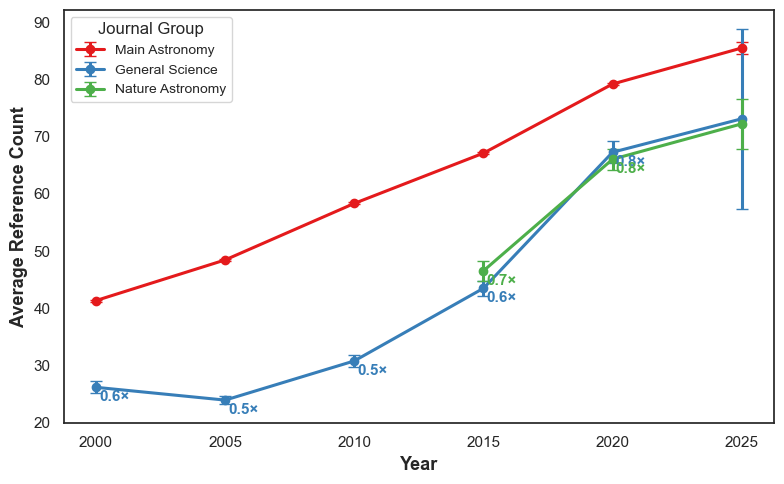

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("figures", exist_ok=True)

# Re-import necessary packages after code state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def compute_avg_references_grouped(
    df, journal_groups, bin_size=1, year_col='year', reference_col='n_references', journal_col='journal'
):
    """
    Computes average references stats per group of journals, per year bin.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        journal_groups (dict): Keys are group names, values are lists of journal names.
        bin_size (int): Size of year bin (e.g. 2 = 2-year bins)
        year_col (str): Column name with year info.
        reference_col (str): Column name with references counts.
        journal_col (str): Column name with journal names.

    Returns:
        pd.DataFrame with columns: 'group', 'year_bin', 'avg_citations', 'sem_citations'
    """
    results = []

    for group_name, journal_list in journal_groups.items():
        sub_df = df[df[journal_col].isin(journal_list)].copy()
        sub_df['year_bin'] = (sub_df[year_col] // bin_size) * bin_size
        #sub_df['year_bin'] = ((sub_df[year_col] // bin_size) * bin_size) + (bin_size // 2)

        grouped = sub_df.groupby('year_bin')[reference_col].agg(['mean', 'std', 'count']).reset_index()
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped.rename(columns={'mean': 'avg_citations', 'sem': 'sem_citations'}, inplace=True)
        grouped['group'] = group_name
        results.append(grouped[['year_bin', 'avg_citations', 'sem_citations', 'group']])

    return pd.concat(results, ignore_index=True)




def plot_avg_references_grouped_with_ratios(df, keyword='Astronomy', x_col='year_bin'):
    """
    Plots citation trends with standard error for grouped journals.
    Annotates how much higher General Science and Nature Astronomy are compared to Main Astronomy
    for each year bin (excluding the last one).
    """
    sns.set_theme(style='white', context='notebook')
    plt.figure(figsize=(8, 5))

    unique_groups = df['group'].unique()
    palette = sns.color_palette('Set1', n_colors=len(unique_groups))
    group_colors = {group: palette[i] for i, group in enumerate(unique_groups)}

    # Annotate ratios for each bin (excluding the last)
    bins = sorted(df[x_col].unique())[:-1]
    base_group = 'Main Astronomy'


    # Plot lines
    for group_name in unique_groups:
        sub = df[df['group'] == group_name]
        plt.errorbar(
            sub[x_col], sub['avg_citations'], yerr=sub['sem_citations'],
            fmt='-o', label=group_name, capsize=4, linewidth=2.2, color=group_colors[group_name]
        )



    for b in bins:
        base_val = df[(df['group'] == base_group) & (df[x_col] == b)]['avg_citations'].values
        if len(base_val) == 0:
            continue
        base_val = base_val[0]
        for other_group in ['General Science', 'Nature Astronomy']:
            val = df[(df['group'] == other_group) & (df[x_col] == b)]['avg_citations'].values
            if len(val) > 0 and base_val > 0:
                ratio = val[0] / base_val
                plt.annotate(
                    f"{ratio:.1f}×",
                    xy=(b, val[0]),
                    xytext=(13, -10),
                    textcoords='offset points',
                    fontsize=11,
                    ha='center',
                    weight = 'bold', 
                    color=group_colors[other_group]
                )

    plt.xlabel("Year", fontsize=13, weight='bold')
    plt.ylabel("Average Reference Count", fontsize=13, weight='bold')
    plt.legend(title='Journal Group', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/avg_references_grouped_with_ratios_{keyword}.png", dpi=300)
    plt.show()

# Define the grouped journals
journal_groups = {
    "Main Astronomy": ['ApJ', 'A&A', 'MNRAS'],
    "General Science": ['Sci', 'Natur'],
    "Nature Astronomy": ['NatAs']
}

# Compute grouped averages
avg_cit_grouped_df = compute_avg_references_grouped(
    df=all_data_ref_clean,
    journal_groups=journal_groups,
    bin_size=5  # 2-year bins
)

# Plot
plot_avg_references_grouped_with_ratios(avg_cit_grouped_df, keyword='Astronomy')


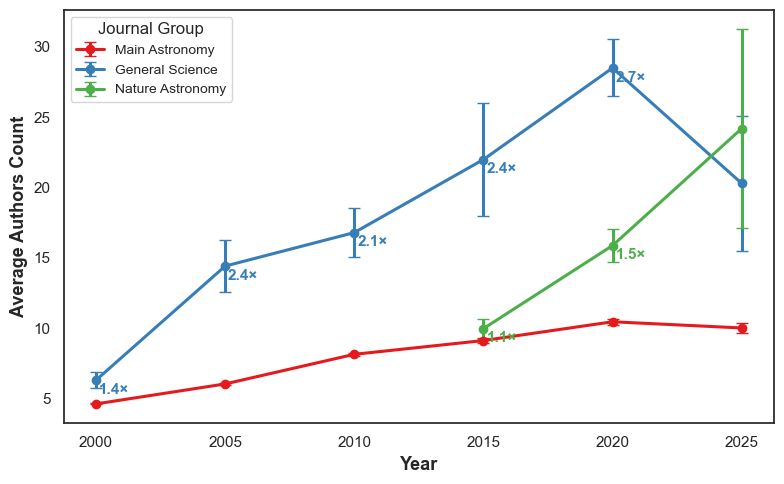

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("figures", exist_ok=True)

# Re-import necessary packages after code state reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def compute_avg_authors_grouped(
    df, journal_groups, bin_size=1, year_col='year', reference_col='n_authors', journal_col='journal'
):
    """
    Computes average references stats per group of journals, per year bin.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        journal_groups (dict): Keys are group names, values are lists of journal names.
        bin_size (int): Size of year bin (e.g. 2 = 2-year bins)
        year_col (str): Column name with year info.
        reference_col (str): Column name with references counts.
        journal_col (str): Column name with journal names.

    Returns:
        pd.DataFrame with columns: 'group', 'year_bin', 'avg_citations', 'sem_citations'
    """
    results = []

    for group_name, journal_list in journal_groups.items():
        sub_df = df[df[journal_col].isin(journal_list)].copy()
        sub_df['year_bin'] = (sub_df[year_col] // bin_size) * bin_size
        #sub_df['year_bin'] = ((sub_df[year_col] // bin_size) * bin_size) + (bin_size // 2)

        grouped = sub_df.groupby('year_bin')[reference_col].agg(['mean', 'std', 'count']).reset_index()
        grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])
        grouped.rename(columns={'mean': 'avg_citations', 'sem': 'sem_citations'}, inplace=True)
        grouped['group'] = group_name
        results.append(grouped[['year_bin', 'avg_citations', 'sem_citations', 'group']])

    return pd.concat(results, ignore_index=True)




def plot_avg_references_grouped_with_ratios(df, keyword='Astronomy', x_col='year_bin'):
    """
    Plots citation trends with standard error for grouped journals.
    Annotates how much higher General Science and Nature Astronomy are compared to Main Astronomy
    for each year bin (excluding the last one).
    """
    sns.set_theme(style='white', context='notebook')
    plt.figure(figsize=(8, 5))

    unique_groups = df['group'].unique()
    palette = sns.color_palette('Set1', n_colors=len(unique_groups))
    group_colors = {group: palette[i] for i, group in enumerate(unique_groups)}

    # Annotate ratios for each bin (excluding the last)
    bins = sorted(df[x_col].unique())[:-1]
    base_group = 'Main Astronomy'


    # Plot lines
    for group_name in unique_groups:
        sub = df[df['group'] == group_name]
        plt.errorbar(
            sub[x_col], sub['avg_citations'], yerr=sub['sem_citations'],
            fmt='-o', label=group_name, capsize=4, linewidth=2.2, color=group_colors[group_name]
        )



    for b in bins:
        base_val = df[(df['group'] == base_group) & (df[x_col] == b)]['avg_citations'].values
        if len(base_val) == 0:
            continue
        base_val = base_val[0]
        for other_group in ['General Science', 'Nature Astronomy']:
            val = df[(df['group'] == other_group) & (df[x_col] == b)]['avg_citations'].values
            if len(val) > 0 and base_val > 0:
                ratio = val[0] / base_val
                plt.annotate(
                    f"{ratio:.1f}×",
                    xy=(b, val[0]),
                    xytext=(13, -10),
                    textcoords='offset points',
                    fontsize=11,
                    ha='center',
                    weight = 'bold', 
                    color=group_colors[other_group]
                )

    plt.xlabel("Year", fontsize=13, weight='bold')
    plt.ylabel("Average Authors Count", fontsize=13, weight='bold')
    plt.legend(title='Journal Group', fontsize=10)
    plt.tight_layout()
    plt.savefig(f"figures/avg_authors_grouped_with_ratios_{keyword}.png", dpi=300)
    plt.show()

# Define the grouped journals
journal_groups = {
    "Main Astronomy": ['ApJ', 'A&A', 'MNRAS'],
    "General Science": ['Sci', 'Natur'],
    "Nature Astronomy": ['NatAs']
}

# Compute grouped averages
avg_cit_grouped_df = compute_avg_authors_grouped(
    df=all_data_ref_clean,
    journal_groups=journal_groups,
    bin_size=5  # 2-year bins
)

# Plot
plot_avg_references_grouped_with_ratios(avg_cit_grouped_df, keyword='Astronomy')


In [40]:
from scipy.stats import pearsonr

def compute_yearly_correlation_per_journal(
    df, journal_list, citation_col='citation_count', reference_col='n_references',
    journal_col='journal', year_col='year', min_n=10
):
    """
    Computes Pearson correlation between citation counts and reference counts
    for each journal in the list, for each year.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        journal_list (list): List of journal names to include.
        citation_col (str): Column for citation counts.
        reference_col (str): Column for reference counts.
        journal_col (str): Column for journal names.
        year_col (str): Column for publication year.
        min_n (int): Minimum number of papers per year-journal combo to compute correlation.

    Returns:
        pd.DataFrame: DataFrame with columns: 'journal', 'year', 'n_articles', 'pearson_r', 'p_value'
    """
    results = []

    for journal in journal_list:
        sub_df = df[df[journal_col] == journal]

        for year in sorted(sub_df[year_col].dropna().unique()):
            year_df = sub_df[sub_df[year_col] == year][[citation_col, reference_col]].dropna()

            if len(year_df) >= min_n:
                r, p = pearsonr(year_df[reference_col], year_df[citation_col])
                results.append({
                    'journal': journal,
                    'year': int(year),
                    'n_articles': len(year_df),
                    'pearson_r': r,
                    'p_value': p
                })

    return pd.DataFrame(results)

correlation_cite_ref_df = compute_yearly_correlation_per_journal(
    df=all_data_ref_clean,
    journal_list=['A&A', 'MNRAS', 'ApJ', 'Sci', 'Natur', 'NatAs'],
    min_n=15  # skip year-journal combos with fewer than 15 articles
)

correlation_cite_ref_df.groupby('journal').mean()


,year,n_articles,pearson_r,p_value
journal,,,,
A&A,2012.500000,1482.884615,0.250310,8.158309e-07
ApJ,2012.500000,2467.615385,0.271752,2.154106e-11
MNRAS,2012.500000,1951.884615,0.300411,1.620704e-07
NatAs,2021.000000,75.888889,0.176550,2.965574e-01
Natur,2012.500000,50.875000,0.326335,1.423200e-01
Sci,2009.058824,21.705882,0.304155,2.602619e-01
